In [1]:
"""
Copy-pasted imports from this week's example code.
"""

import tensorflow as tf

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

---

In [2]:
"""
Fetching the training images and storing their corresponding labels.
"""

from matplotlib import image

directories = [
    '.\\flowers\\black_eyed_susan',    # Label 0
    '.\\flowers\\common_daisy',        # Label 1
    '.\\flowers\\sunflower'            # Label 2
]

train_images = []
train_labels = []

directories_index = 0
for directory in directories:
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath) and filepath[-4:] == '.jpg':
            train_images.append(image.imread(filepath))
            train_labels.append(directories_index)
    directories_index += 1

train_images = np.array(train_images).astype('float32')
train_images = (train_images - 127.5) / 127.5
train_labels = np.array(train_labels)

In [3]:
"""
Creating a dataset object using this week's example code.
"""

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [4]:
"""
Creating a function that returns a generator model using a slightly modified version of this week's example code.
"""

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(32 * 32 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((32, 32, 256)))
    assert model.output_shape == (None, 32, 32, 256)
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 256, 256, 3)

    return model

In [5]:
"""
Creating a function that returns a discriminator model using a slightly modified version of this week's example code.
"""

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[256, 256, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [6]:
"""
N/A
"""

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

####################################################################

generator = make_generator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

####################################################################

discriminator = make_discriminator_model()
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [7]:
"""
Creating a seed for the GAN model using this week's example code (and defining its number of epochs).
"""

EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [8]:
"""
Creating a training step function using this week's example code.
"""

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [9]:
"""
Setting up a checkpoint functionality using this week's example code.
"""

checkpoint_dir = '.\\training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator)

In [10]:
"""
Defining a training function using this week's example code.
"""

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [11]:
"""
Defining a function to generate and save images produced by the generator using this week's example code.
"""

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        img_arr = predictions[i].numpy()
        plt.imshow((img_arr[:, :, :] * 127.5 + 127.5).astype(np.uint8))
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

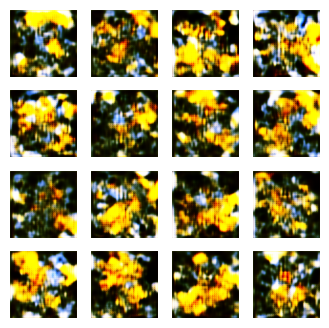

Time for epoch 183 is 271.29985761642456 sec


In [ ]:
"""
Training the GAN model.
"""

train(train_dataset, EPOCHS)